In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sys, os
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent))

from general.pulses import blackman_pulse, square_pulse

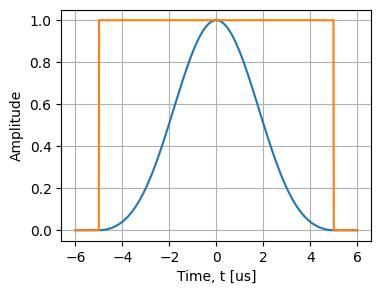

In [7]:
t = np.linspace(-6, 6, 1000)
t_width = 10

fig, ax = plt.subplots(figsize=(4,3))

ax.plot(t, blackman_pulse(t+t_width/2, t_width))
ax.plot(t, square_pulse(t+t_width/2, t_width))
ax.grid(True)
ax.set(xlabel="Time, t [us]", ylabel="Amplitude")

plt.show()

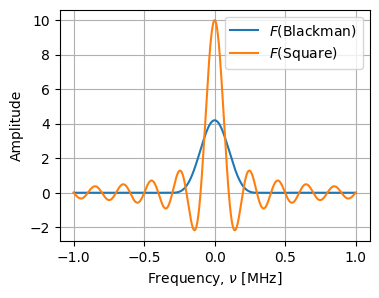

In [16]:
from general.pulses import blackman_fourier

nu = np.linspace(-1, 1, 1000)
t_width = 10

fig, ax = plt.subplots(figsize=(4,3))

ax.plot(nu, blackman_fourier(nu, t_width), label=r'$F$(Blackman)')
ax.plot(nu, t_width*np.sinc(t_width*nu), label=r'$F$(Square)')
ax.grid(True)
ax.set(xlabel=r"Frequency, $\nu$ [MHz]", ylabel="Amplitude")
ax.legend(loc="upper right")

plt.show()

Average SquareFourier^2 at large x compared to BlackmanFourier^2 is 4.217287374647689e-64


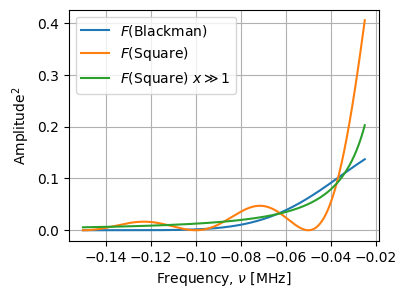

In [45]:
from general.pulses import blackman_fourier

nu_test = -0.15
nu = np.linspace(nu_test, -0.025, 1000)
t_width = 20

def large_x_sinc(x):
    return 1/np.sqrt(2)* np.piecewise(x, [x==0, x!=0], [1, lambda x: 1/(np.pi * x)])

fig, ax = plt.subplots(figsize=(4,3))

ax.plot(nu, (blackman_fourier(nu, t_width)/t_width)**2, label=r'$F$(Blackman)')
ax.plot(nu, np.sinc(t_width*nu)**2, label=r'$F$(Square)')
ax.plot(nu, large_x_sinc(t_width*nu)**2, label=r'$F$(Square) $x\gg1$') 
ax.grid(True)
ax.set(xlabel=r"Frequency, $\nu$ [MHz]", ylabel=r"Amplitude$^2$")
ax.legend(loc="upper left")

ratio = (blackman_fourier(nu_test, t_width)/t_width)**2/large_x_sinc(t_width*nu_test)**2

print(f"Average SquareFourier^2 at large x compared to BlackmanFourier^2 is {ratio}")

plt.show()

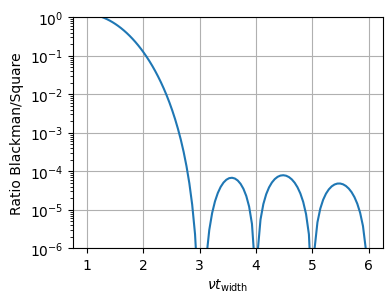

In [44]:
fig, ax = plt.subplots(figsize=(4,3))

detuning = np.linspace(1, 6, 100)

def ratio_func(det):
    return (blackman_fourier(det, 1))**2/large_x_sinc(det)**2

ax.plot(detuning, ratio_func(detuning))
ax.grid(True)
ax.set(xlabel=r"$\nu t_\mathrm{width}$", ylabel=r"Ratio Blackman/Square",
       yscale='log', ylim=(10e-7, 1))

plt.show()

## Convolution of Blackman on -3/2s tail

In [164]:
from scipy.signal import fftconvolve

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# --- Parameters ---
# Time widths of Blackman window .
t_list = np.array([2.5, 5, 10, 20, 40, 80, 160, 320, 600, 1.2e3, 2.4e3])   

nu_s = 0.150            # Frequency shift of Blackman window.
gamma = 0.005            # Lorentzian HWHM (broad).
nu0 = 0.0              # Lorentzian center frequency.
x_i = gamma             # Lorentzian to -3/2s tail roll-over.
U_trap = 0.2            # Trap depth

# --- Frequency grid ---
samples = 5e5
nu = np.linspace(-2, 2, int(samples))
ind_nu_s = np.argmin(np.abs(nu - nu_s))  # Find index of closest value to nu_s.
ind_x_i = np.argmin(np.abs(nu - x_i))  # Find index of closest value to x_i.

# --- Shifted Blackman FT ---
B = lambda t_width: (blackman_fourier(nu - nu_s, t_width)/t_width)**2

# --- Response ---
def lorentzian(nu):
    return 1 / (1 + ((nu - nu0) / gamma) ** 2)

L = lorentzian(nu)

def spectrum(nu, x_i):
    cond_list = [nu <= x_i, nu > 0]
    crossover_y = lorentzian(x_i) * x_i**(3/2)
    func_list = [lorentzian, lambda x: crossover_y*x**(-3/2)]
    return np.piecewise(nu, cond_list, func_list)

S = spectrum(nu, x_i=x_i)

# --- Convolution (normalized) ---
C = np.array([fftconvolve(S, B(t), mode='same') for t in t_list])
C /= np.max(C[0])  # Normalize arbitrarily for clarity.

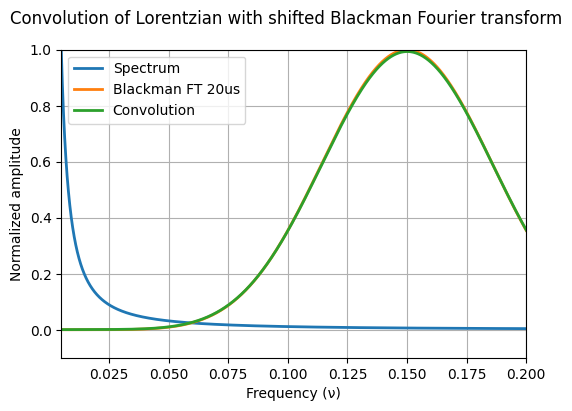

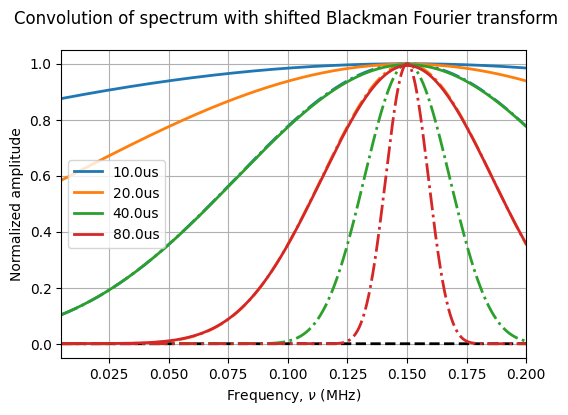

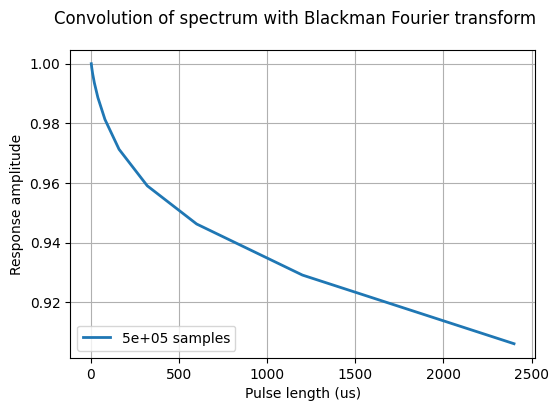

In [165]:
# --- Plot results ---
fig, ax = plt.subplots(figsize=(6, 4))
# plt.plot(nu, L / np.max(L), label="Lorentzian", color="tab:blue", lw=2)
ax.plot(nu, S / np.max(S[ind_x_i]), label="Spectrum", color="tab:blue", lw=2)
ax.plot(nu, B(20) / np.max(B(20)), label="Blackman FT 20us", color="tab:orange", lw=2)
ax.plot(nu, C[3], label="Convolution", color="tab:green", lw=2)
fig.suptitle("Convolution of Lorentzian with shifted Blackman Fourier transform")
ax.set(xlabel="Frequency (ν)", ylabel="Normalized amplitude", xlim=(x_i, U_trap),
       ylim=(-0.1, 1))
ax.grid(True)
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(nu, S / np.max(S), "--k", lw=2)
for i, t in enumerate(t_list[2:6]):
    color = colors[i]
    plt.plot(nu, C[i], '-', label=f"{t}us", lw=2, color=color)
    plt.plot(nu, B(t) / np.max(B(t)), '-.', lw=2, color=colors[i])
fig.suptitle("Convolution of spectrum with shifted Blackman Fourier transform")
ax.set(xlabel=r"Frequency, $\nu$ (MHz)", ylabel="Normalized amplitude", xlim=(x_i, U_trap))
ax.grid(True)
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(t_list, [Ci[ind_nu_s] for Ci in C], lw=2, label=f'{samples:.0e} samples')
# ax.plot(t_list, lin_func(t_list), '--')
# ax.plot(t_list, v_low_samples_C, lw=2, label='5e3 samples')
# # ax.plot(t_list, low_samples_C, lw=2, label='5e4 samples')
# ax.plot(t_list, med_samples_C, lw=2, label='5e5 samples')
# ax.plot(t_list, many_samples_C, lw=2, label='5e6 samples')
ax.legend(loc='lower left')

fig.suptitle("Convolution of spectrum with Blackman Fourier transform")
ax.set(xlabel="Pulse length (us)", ylabel="Response amplitude")
ax.grid(True)
plt.show()

In [143]:
slope = (C[-1][ind_nu_s] - C[-2][ind_nu_s])/(t_list[-1] - t_list[-2])
offset = C[-2][ind_nu_s] - slope * t_list[-2]
lin_func = lambda t: slope * t + offset

In [151]:
many_samples_C = [Ci[ind_nu_s] for Ci in C]

In [ ]:
# low_samples_C = [Ci[ind_nu_s] for Ci in C]

In [ ]:
# med_samples_C = [Ci[ind_nu_s] for Ci in C]

In [121]:
v_low_samples_C = [Ci[ind_nu_s] for Ci in C]

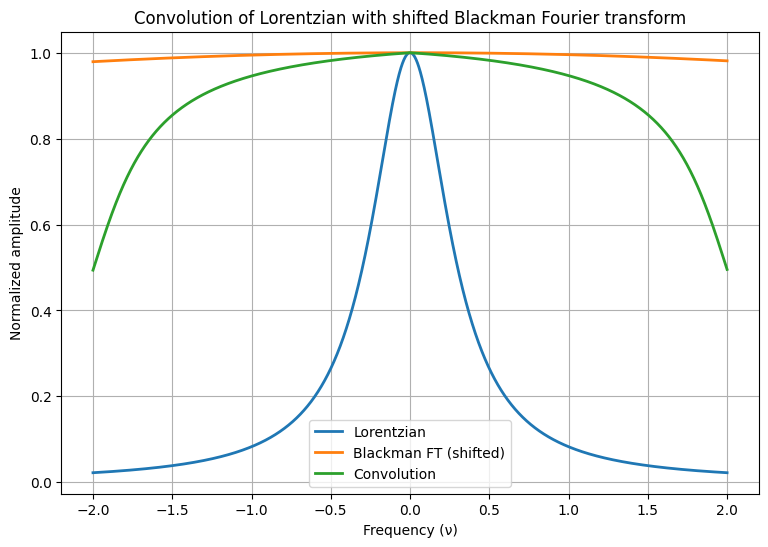

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve

# --- Parameters ---
alpha = 0.16           # Blackman parameter
a0 = (1 - alpha) / 2
a1 = 0.5
a2 = alpha / 2
t_w = 0.1              # time width of Blackman window (smaller => broader in freq)
nu_s = 0.05            # frequency shift of Blackman window
gamma = 0.3            # Lorentzian HWHM (broad)
nu0 = 0.0              # Lorentzian center frequency

# --- Frequency grid ---
nu = np.linspace(-2, 2, 5000)

# --- Normalized sinc function ---
def sinc(x):
    return np.sinc(x)  # numpy's sinc(x) = sin(pi x)/(pi x)

# --- Blackman Fourier Transform (real and even) ---
def F_blackman(nu):
    return t_w * (
        a0 * sinc(t_w * nu)
        + (a1 / 2) * (sinc(t_w * (nu - 1 / t_w)) + sinc(t_w * (nu + 1 / t_w)))
        + (a2 / 2) * (sinc(t_w * (nu - 2 / t_w)) + sinc(t_w * (nu + 2 / t_w)))
    )

# Shifted Blackman FT
B = F_blackman(nu - nu_s)

# --- Lorentzian response ---
L = 1 / (1 + ((nu - nu0) / gamma) ** 2)

# --- Convolution (normalized) ---
C = fftconvolve(L, B, mode='same')
C /= np.max(C)  # normalize to 1 for clarity

# --- Plot results ---
plt.figure(figsize=(9, 6))
plt.plot(nu, L / np.max(L), label="Lorentzian", color="tab:blue", lw=2)
plt.plot(nu, B / np.max(B), label="Blackman FT (shifted)", color="tab:orange", lw=2)
plt.plot(nu, C, label="Convolution", color="tab:green", lw=2)
plt.title("Convolution of Lorentzian with shifted Blackman Fourier transform")
plt.xlabel("Frequency (ν)")
plt.ylabel("Normalized amplitude")
plt.grid(True)
plt.legend()
plt.show()


## Plot for figures

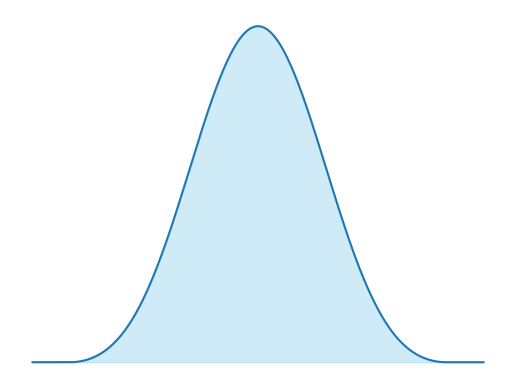

In [4]:
t = np.linspace(-0.1, 1.1, 1000)
t_width = 1

y = blackman_pulse(t, t_width)

fig, ax = plt.subplots()
ax.plot(t, y)
ax.fill_between(t, y, color='skyblue', alpha=0.4) 
# plt.plot(t, square_pulse(t, t_width))
ax.set(xlabel="Time, t", ylabel="Amplitude")

ax.axis('off')

plt.show()

# fig.savefig("outputs/blackman_envelope_with_fill.pdf")

## Understanding a_1 coefficient sign

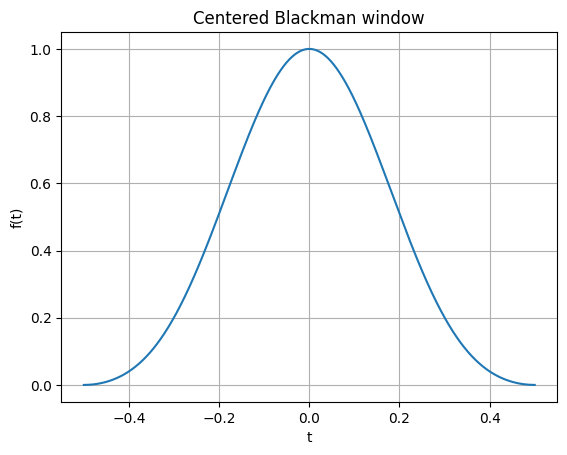

In [5]:
import numpy as np
import matplotlib.pyplot as plt

alpha = 0.16
a0 = (1 - alpha)/2
a1 = 0.5
a2 = alpha/2

t_w = 1.0
t = np.linspace(-t_w/2, t_w/2, 1000)
f = a0 + a1*np.cos(2*np.pi*t/t_w) + a2*np.cos(4*np.pi*t/t_w)

plt.plot(t, f)
plt.title("Centered Blackman window")
plt.xlabel("t")
plt.ylabel("f(t)")
plt.grid(True)
plt.show()
